### Exact-solution dataset for low-rank-affine morph

In [2]:
%load_ext autoreload
%autoreload 3 --print

In [19]:
from kpsn_test.routines.datasets import npy_keypts
from kpsn_test.routines.datasets import blscale
from kpsn_test.routines.util import update
from kpsn_test import visualize as viz
from kpsn.util import keypt_io, alignment

from mph.data_explore.lib.morphs import linear_skeletal as ls
# from mph.data_explore.lib import skeleton
from kpsn.util import skeleton

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/lra_exact_dataset'

### Load data, sample parameters, and run morph

In [13]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models import pose

import jax.random as jr

In [14]:
cfg = dict(
    src_sess = '3wk_m0',
    n_subj = 3,
    hyperparam = dict(
        L = 1,
    ),
    param_sample = dict(
        update_std = 0.03,
        offset_std = 0.5
    ),
    seed = 2
)

In [15]:
(N, M), gt_obs, metadata = npy_keypts.generate(
    cfg = update(npy_keypts.defaults, dict(
        path = '../../../data_explore/data',
        output_indep = True,
        age_blacklist = [9, 12]
)))
ref_slices = metadata['session_slice']

In [16]:
src_keypts = gt_obs.keypts[metadata['session_slice'][cfg['src_sess']]]
slices, gt_all_poses = keypt_io.to_flat_array({
    f'subj{i}': src_keypts for i in range(cfg['n_subj'])
})
session_ix, session_ids = keypt_io.ids_from_slices(gt_all_poses, slices)

morph_hyperparams = afm.init_hyperparams(
    observations = pose.Observations(gt_all_poses, session_ids),
    N = cfg['n_subj'], M = M,
    reference_subject = session_ix['subj0'],
    identity_sess = session_ix['subj0'],
    upd_var_modes = 0, # prior variance params don't matter - not learning
    upd_var_ofs = 0,
    **cfg['hyperparam'])

morph_params = afm.sample_parameters(
    rkey = jr.PRNGKey(cfg['seed']),
    hyperparams = morph_hyperparams,
    **cfg['param_sample'])

params = morph_params.with_hyperparams(morph_hyperparams)

new_metadata = dict(
    session_ix = session_ix,
    session_slice = slices,
    body = {f'subj{i}': i for i in range(cfg['n_subj'])},
    **{k: {sess: v[cfg['src_sess']] for sess in slices}
       for k, v in metadata.items() if k not in ['session_ix']
       if k not in ['session_ix', 'session_slice']})

all_feats = afm.transform(params, gt_all_poses, session_ids)

In [20]:
all_keypts = alignment.sagittal_align_insert_redundant_subspace(
    all_feats, 'hips', skeleton.default_armature)

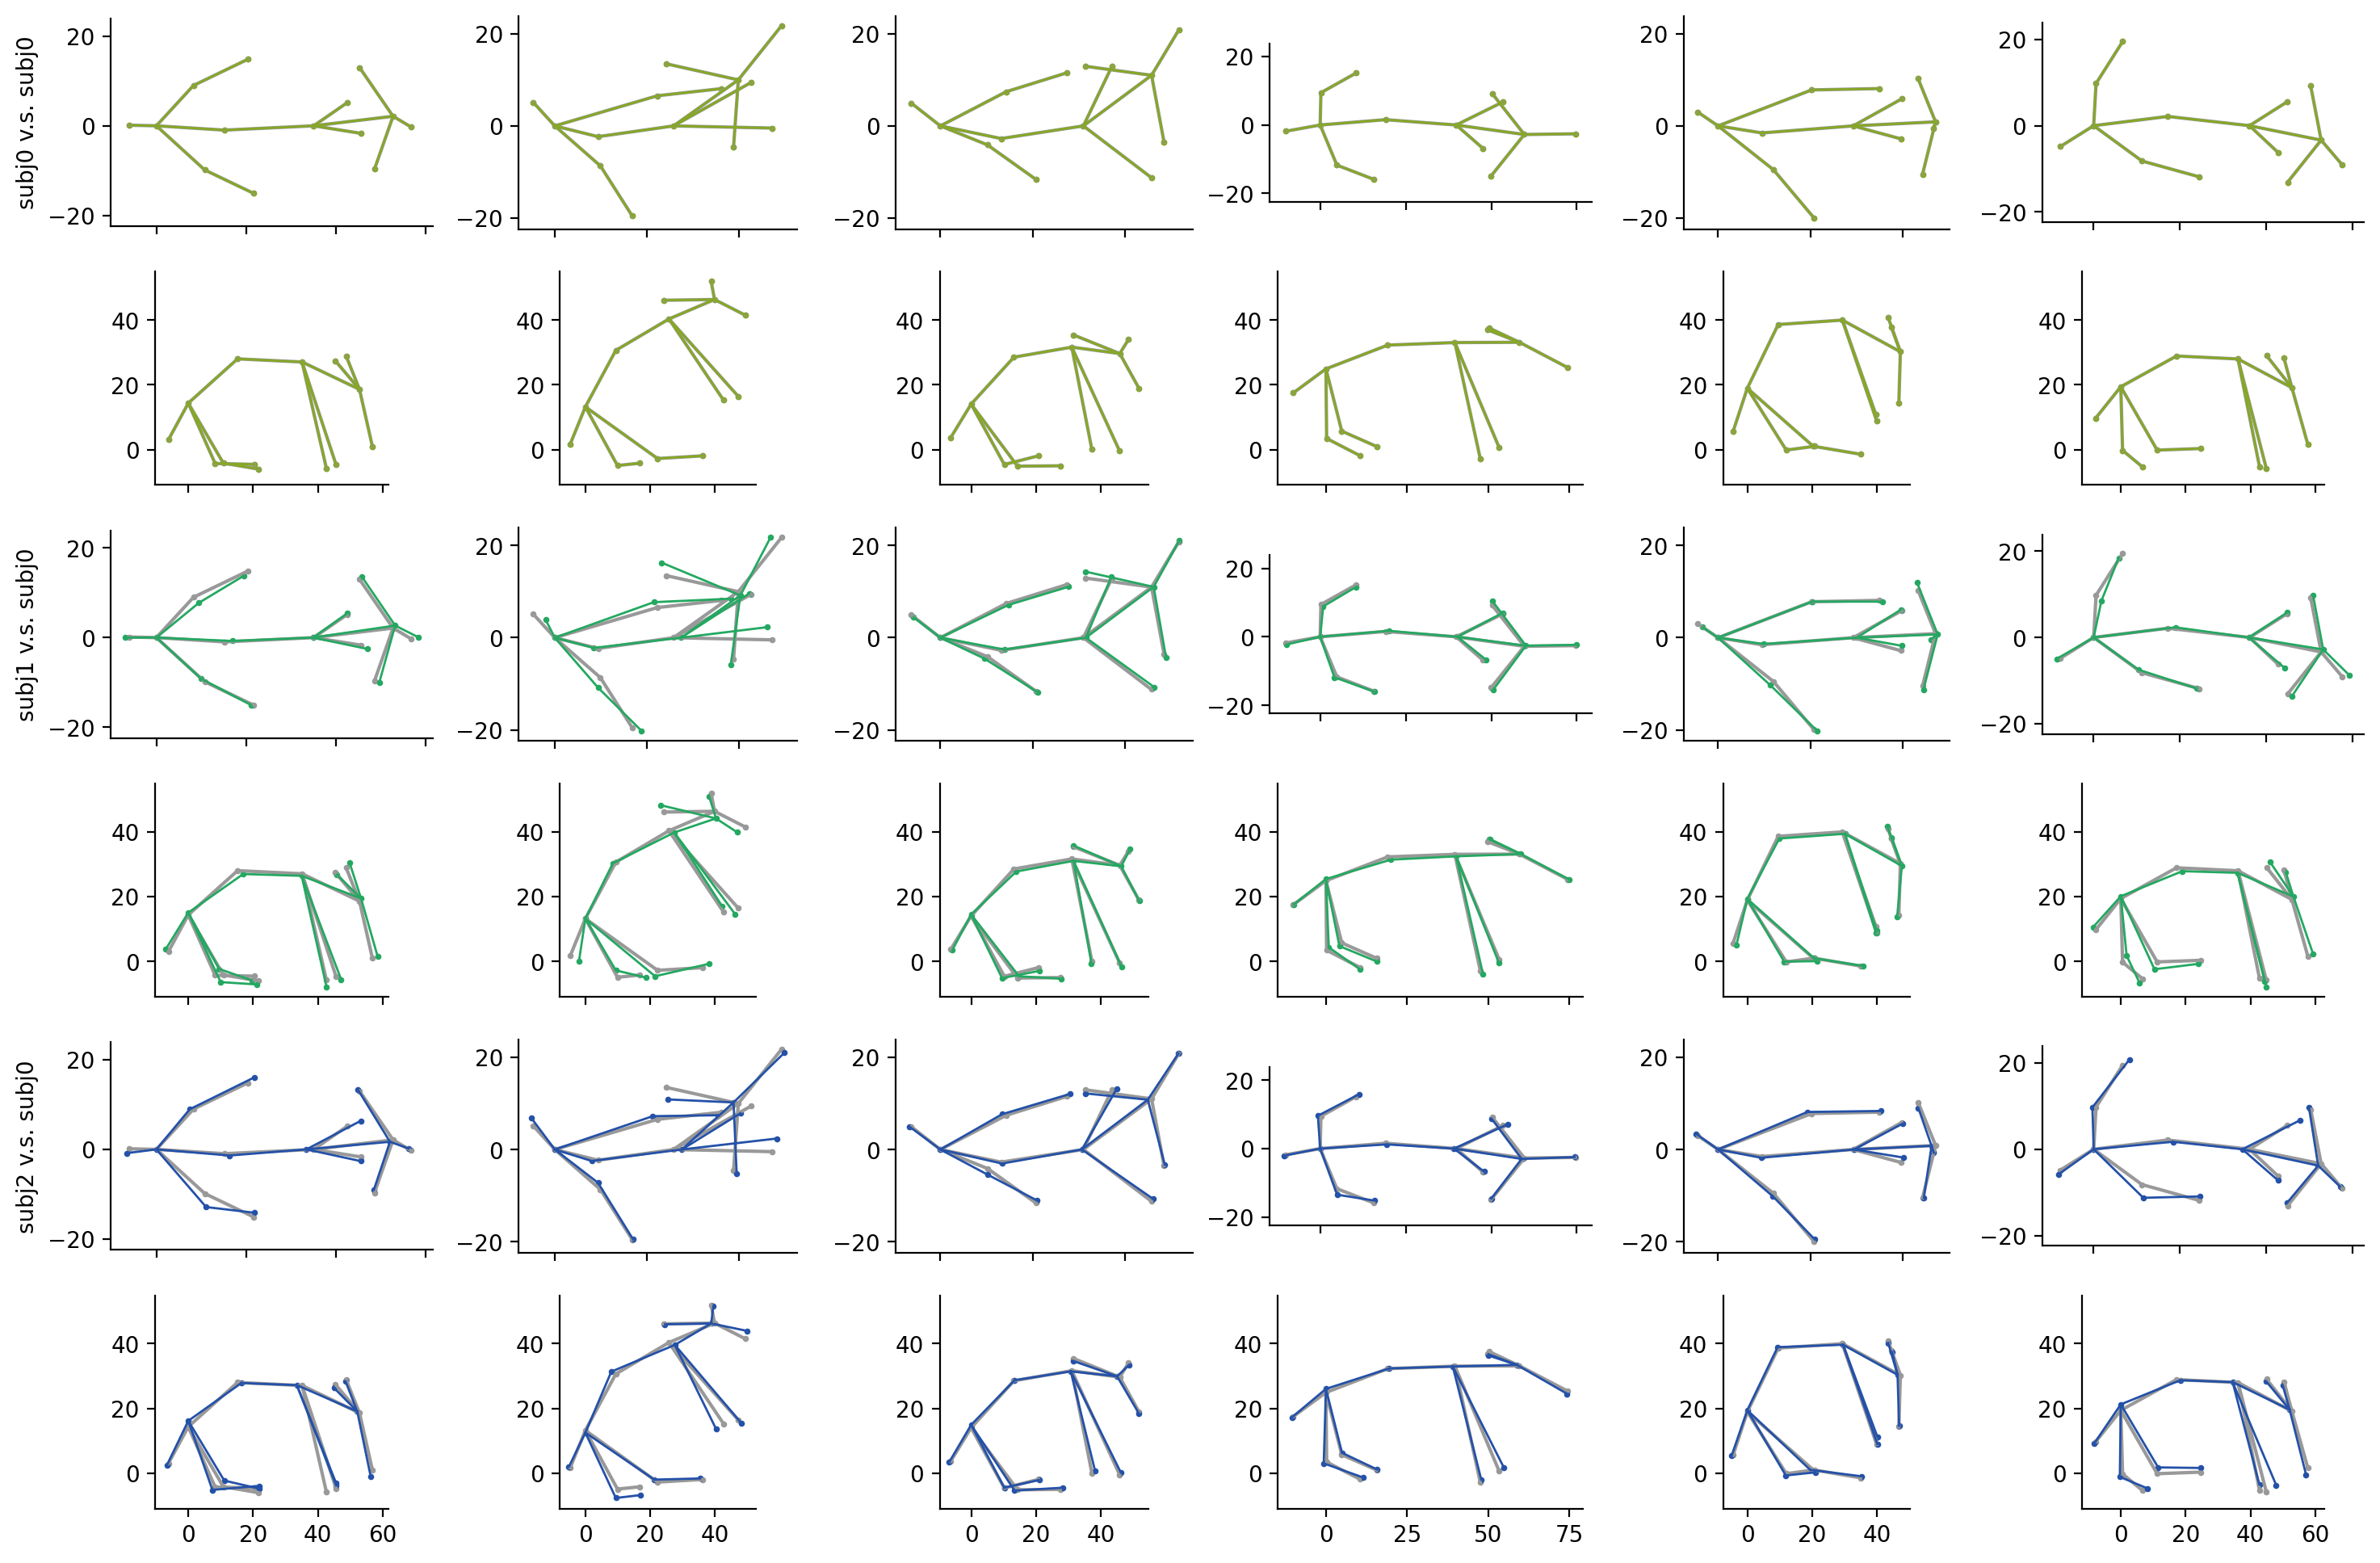

In [21]:
meta = new_metadata
frames = viz.diagram_plots.pose_gallery_ixs(
    all_keypts[meta['session_slice']['subj0']],
    skeleton.default_armature)

bodies, body_groups = keypt_io.get_groups_dict(meta['body'])
pal = viz.defaults.age_pal(meta['body'])

fig, ax = plt.subplots(
    nrows = 2*len(meta['body']), ncols = len(frames),
    figsize = (3 * len(frames), 4 * cfg['n_subj']), sharex = 'col')

for i_frame, (frame_name, frame) in enumerate(frames.items()):
    for i_body, (body, body_group) in enumerate(zip(bodies, body_groups)):
        tgt_sess = body_group[0]
        tgt_slc = meta['session_slice'][tgt_sess]
        src_slc = meta['session_slice']['subj0']
        for row_ofs, xaxis, yaxis in [(0, 0, 1), (1, 0, 2)]:
            ax[2*i_body + row_ofs, i_frame].sharey(ax[row_ofs, 0])
            viz.diagram_plots.plot_mouse(
                ax[2*i_body + row_ofs, i_frame],
                all_keypts[src_slc][frame].reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': '.6'},
                line_kw = {'color': '.6'})
            viz.diagram_plots.plot_mouse(
                ax[2*i_body + row_ofs, i_frame],
                all_keypts[tgt_slc][frame].reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': pal[body]},
                line_kw = {'color': pal[body], 'lw': 1})
        
sns.despine()
plt.show()

### Diagnose low ill-posed dimension

In [336]:
from sklearn.decomposition import PCA
from kpsn_test.routines.datasets import lra_keypts

(N, M), gt_obs, metadata = lra_keypts.generate(update(lra_keypts.defaults, dict(
    path = "../../../data_explore/data",
    src_sess = '3wk_m0',
    age_blacklist = [9,12],
    subsample=15,
    output_indep = True,
    n_subj = 4,
    seed = 5,
    param_sample = dict(
        update_std = 0.03,
        offset_std = 3
    ),
)))


Reloading 'kpsn.util.alignment'.


In [337]:
pc = PCA(n_components = gt_obs.keypts.shape[-1]).fit(gt_obs.keypts)

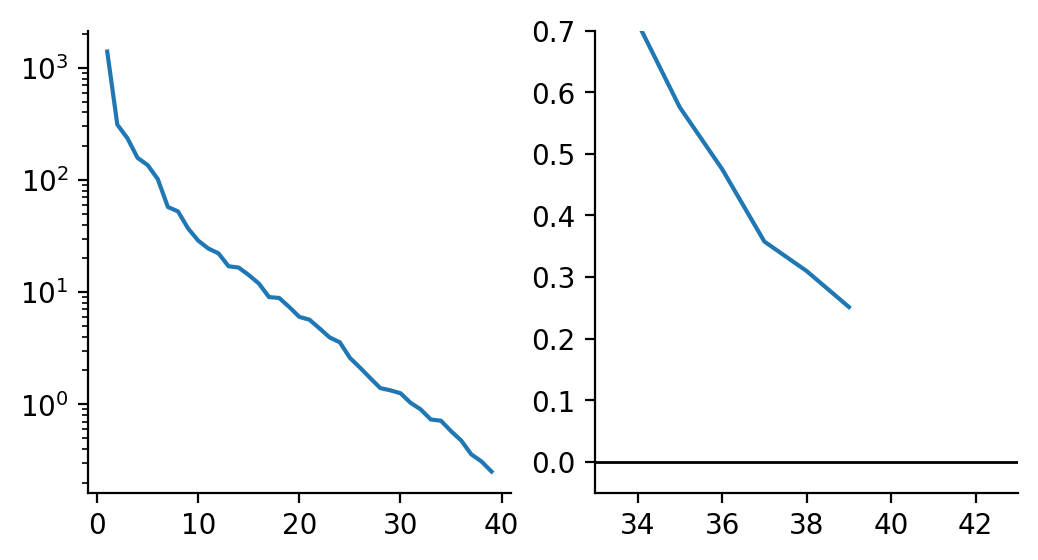

In [338]:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
ax[0].plot(np.arange(1, gt_obs.keypts.shape[-1] + 1), pc.explained_variance_)
ax[0].set_yscale('log')
ax[1].plot(np.arange(1, gt_obs.keypts.shape[-1] + 1), pc.explained_variance_)
ax[1].axhline(0, color = 'k', lw = 1)
ax[1].set_xlim(33, 43)
ax[1].set_ylim(-0.05, 0.7)
sns.despine()

In [339]:
from kpsn_test.routines.models import lra as lra_routine
from kpsn_test.routines.models import gmm as gmm_routine
from kpsn.models import joint_model

model = joint_model.JointModel(
    morph = lra_routine.model,
    posespace = gmm_routine.model)

pose_hyperparams = model.posespace.init_hyperparams(
    N = N, M = M,
    **gmm_routine.defaults['hyperparam'])

morph_hyperparams = model.morph.init_hyperparams(
    observations = gt_obs,
    N = N, M = M,
    reference_subject = metadata['session_ix']['subj0'],
    **lra_routine.defaults['hyperparam'])

hyperparams = joint_model.JointHyperparams(
    morph = morph_hyperparams,
    posespace = pose_hyperparams)

init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = metadata['session_ix']['subj0'],
    morph_kws = lra_routine.defaults['init'],
    posespace_kws = gmm_routine.defaults['init']
).with_hyperparams(hyperparams)


vals, vecs = np.linalg.eigh(init_params.posespace.covariances())

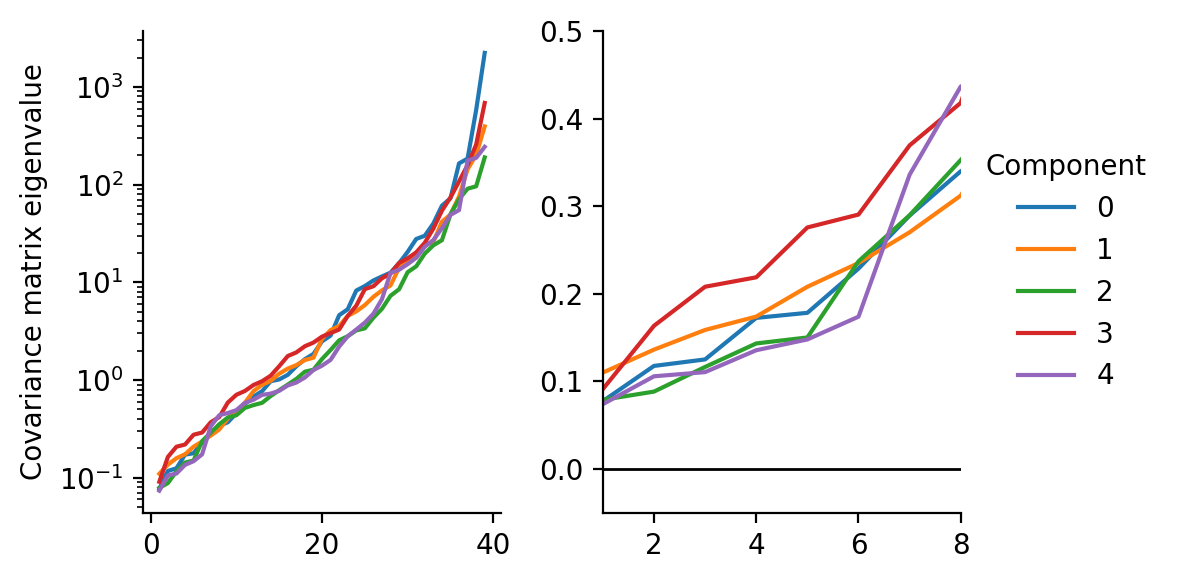

In [340]:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
pal = sns.color_palette("Set1", len(vals))
ndim = vals.shape[-1]
for i in range(len(vals)):
    ax[0].plot(np.arange(1, ndim + 1), vals[i])
    ax[1].plot(np.arange(1, ndim + 1), vals[i], label = f'{i}')
ax[0].set_yscale('log')
ax[0].set_ylabel("Covariance matrix eigenvalue")
ax[1].axhline(0, color = 'k', lw = 1)
ax[1].set_xlim(1, 8)
ax[1].set_ylim(-0.05, 0.5)
plt.legend(frameon = False, bbox_to_anchor = (1, 0.5), loc = 'center left', title = 'Component')

sns.despine()
plt.tight_layout()
fig.savefig(f'{plot_dir}/fixed-cov-eigs.png', dpi=300)

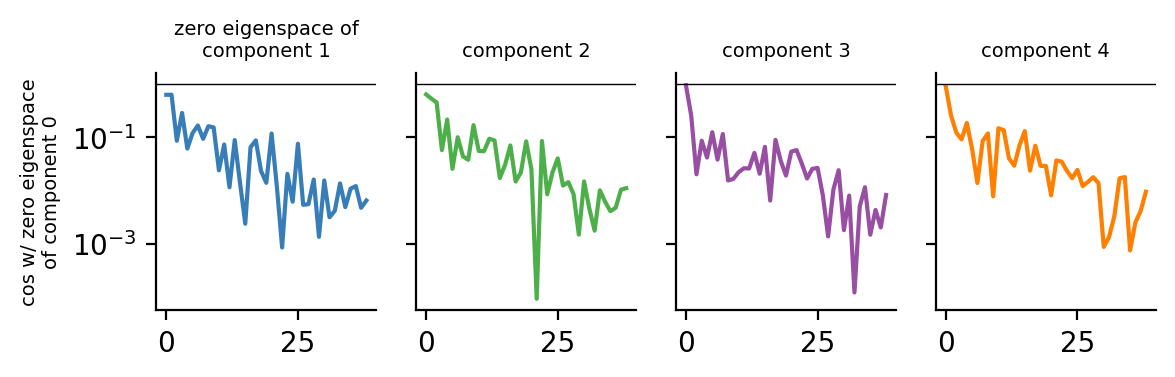

In [341]:
fig, ax = plt.subplots(1, len(vals) - 1, figsize = (6, 2), sharey = True)
for i in range(1, len(vals)):
    dots = (vecs[0, :, 0, None] * vecs[i, :, :]).sum(axis = 0)
    ax[i-1].plot(abs(dots), color = pal[i])
    ax[i-1].axhline(1, color = 'k', lw = 0.5)
    if i == 1:
        ax[i-1].set_title(f"zero eigenspace of\ncomponent {i}", fontsize = 7)
    else:
        ax[i-1].set_title(f"component {i}", fontsize = 7)
plt.yscale('log')
ax[0].set_ylabel("cos w/ zero eigenspace\nof component 0", fontsize = 7)
sns.despine()
plt.tight_layout()
fig.savefig(f'{plot_dir}/fixed-cov-eigs-are-same.png', dpi=300)

In [342]:
centroid_as_keypts = alignment.sagittal_align_insert_redundant_subspace(
    init_params.posespace.means, 'hips', skeleton.default_armature)
as_keypts = 5 * alignment.sagittal_align_insert_redundant_subspace(
    vecs[:, :, 0], 'hips', skeleton.default_armature) + centroid_as_keypts

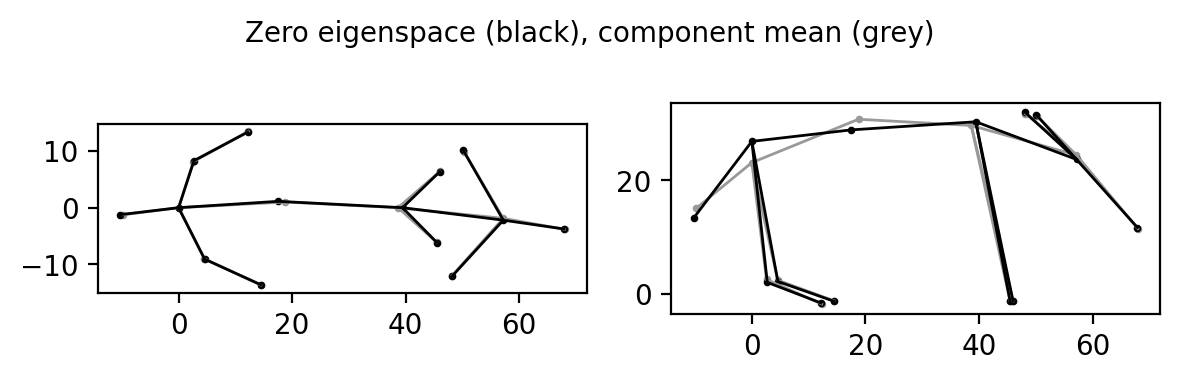

In [343]:
fig, ax = plt.subplots(1, 2, figsize = (6, 1.7))
comp = 4

for (col, xaxis, yaxis) in [(0, 0, 1), (1, 0, 2)]:
    viz.diagram_plots.plot_mouse(
        ax[col],
        centroid_as_keypts[comp].reshape([14, 3]),
        xaxis, yaxis,
        scatter_kw = {'color': '.6'},
        line_kw = {'color': '.6', 'lw': 1})
    viz.diagram_plots.plot_mouse(
        ax[col],
        as_keypts[comp].reshape([14, 3]),
        xaxis, yaxis,
        scatter_kw = {'color': 'k'},
        line_kw = {'color': 'k', 'lw': 1})
plt.suptitle("Zero eigenspace (black), component mean (grey)", fontsize = 10)
plt.tight_layout()
fig.savefig(f'{plot_dir}/fixed-eig-pose.png', dpi=300)

(5, 40)